#Omicron Rising
#Twitter Sentiment Analysis using NLTK and TextBLOB

Noorah Alkhaniny 
MIS64061 (Advanced Machine learning)

In [117]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [118]:
!pip install vaderSentiment

In [119]:
!pip install flair

In [120]:
!pip install pycountry


In [121]:
!pip install emoji

In [122]:
import pycountry
len(pycountry.countries)

249

In [123]:
import numpy as np
import pandas as pd
import emoji
pd.options.mode.chained_assignment = None
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from flair.models import TextClassifier
from flair.data import Sentence
from wordcloud import WordCloud, STOPWORDS


sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

<Figure size 432x288 with 0 Axes>

### Data Loading


In [124]:
df = pd.read_csv("/content/omicron-2.csv")

In [125]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1465693385088323591,Abaris,Hants,"Would appear on Blogger (did originally), but...",2009-09-16 14:30:32,2880,4369,26907,False,2021-11-30 14:45:08,"@SkyNews ""Told you I'd be Back!"" #OMICRON “Odi...",['OMICRON'],Twitter Web App,0,0,False
1,1465693062999412746,GFTs ,Lalaland,There's a field somewhere beyond all doubt and...,2019-12-28 14:29:13,165,583,21152,False,2021-11-30 14:43:52,Someone told me this in October #Omicron https...,['Omicron'],Twitter for Android,0,0,False
2,1465690116442279942,Herbie Finkle (Cozy),NaN,help me find me frens ❤️,2021-07-10 09:40:57,114,393,2339,False,2021-11-30 14:32:09,Glad to see the public schoolkids are wrapping...,['COVID'],Twitter Web App,0,1,False
3,1465689607165591552,Electrical Review,United Kingdom,Electrical Review is a monthly journal aimed a...,2009-05-21 08:32:19,20759,2321,739,False,2021-11-30 14:30:08,#Automation systems have become increasingly c...,['Automation'],Hootsuite Inc.,0,0,False
4,1465688203709464578,BingX Academy 🔑,NaN,BingX (Prev. Bingbon) is the world's top crypt...,2013-12-31 02:57:32,17134,8,31,False,2021-11-30 14:24:33,"🟢 If u think Omicron is a FUD, you LONG📈\n🔴 If...",NaN,Twitter Web App,2,2,False


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21168 entries, 0 to 21167
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                21168 non-null  int64 
 1   user_name         21168 non-null  object
 2   user_location     16055 non-null  object
 3   user_description  19734 non-null  object
 4   user_created      21168 non-null  object
 5   user_followers    21168 non-null  int64 
 6   user_friends      21168 non-null  int64 
 7   user_favourites   21168 non-null  int64 
 8   user_verified     21168 non-null  bool  
 9   date              21168 non-null  object
 10  text              21168 non-null  object
 11  hashtags          15921 non-null  object
 12  source            21168 non-null  object
 13  retweets          21168 non-null  int64 
 14  favorites         21168 non-null  int64 
 15  is_retweet        21168 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 2.3+ MB


There are 21168 tweets, with some nulls values for the columns user_description, user_location and hashtags.


In [127]:
df[df.duplicated()]

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet


## Columns type analysis

In [128]:
df['date'] = pd.to_datetime(df['date'])

In [129]:
df['user_created'] = pd.to_datetime(df['user_created'])

In [130]:
df = df.sort_values('date')

# Tweets analysis

In [131]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
167,1465647564477263872,ANI,India,Asian News International. Multi-media news age...,2011-08-16 05:23:41,6296983,0,1,True,2021-11-30 11:43:04,The discussion on #COVID19 new variant will be...,"['COVID19', 'Omicron']",Twitter Web App,31,440,False
166,1465647574635872266,Nikhil Rampal,"New Delhi, India",Reporter @theprintindia\n\nPolitics/Policy/Gov...,2016-01-15 11:05:07,2903,1022,139624,True,2021-11-30 11:43:06,#Omicron variant news everywhere - I am just r...,['Omicron'],Twitter Web App,0,2,False
165,1465647576363978754,tylaslogrove,"Durban, South Africa",Throw kindness around like confetti✨⭐️💫🌟 ||,2018-07-12 06:29:54,29,164,1811,False,2021-11-30 11:43:07,History has shown that in some previous pandem...,['omicron'],Twitter for iPhone,0,0,False
164,1465647588745658373,BerryNews.org🌱,Den Haag,A news website🌱 developed for expats and local...,2021-09-12 13:34:52,9,177,366,False,2021-11-30 11:43:10,Get the latest news from BerryNews🍓!\nLink in ...,"['Omicron', 'OmicronVariant', 'Omikron', 'Neth...",Twitter Web App,0,0,False
163,1465647609427677184,Oman Observer 🇴🇲,"Muscat, Oman",Delivering global and local news through the e...,2012-11-21 12:28:09,95772,6,6523,True,2021-11-30 11:43:15,Did vaccine inequality lead to the Omicron var...,['Omicron'],Twitter Web App,0,3,False


#Geographical Analysis

For the geographical analysis I will be using the pycountry library and a 'for' loop. Creating a list 'countries' to host the extracted countries from the user_location column.


In [132]:
df['user_location'].value_counts()

India                  1458
Los Angeles, CA         867
New Delhi, India        452
Mumbai, India           284
London, England         231
                       ... 
Galveston, TX             1
London EC1Y England       1
parent's heart ♥          1
Dunder Miffin             1
London/Tumblr             1
Name: user_location, Length: 4346, dtype: int64

India has the highest number of tweets but I would like to show more in depth analysis in the next step

In [133]:
countries_list = []
for i in list(pycountry.countries):
    countries_list.append(i.name)

In [134]:
countries = []
for c1 in df.user_location.values:
    if type(c1) != str:
        countries.append(np.nan)
    else:
        cnt=0 ##counter to check if we arrived at the end of the country list
        for c2 in countries_list:
            if c2 in c1:
                countries.append(c2)
                break
            else:
                cnt+=1
                if cnt== len(countries_list):
                    countries.append(np.nan)

In [135]:
countries.count(np.nan)

14529

We have 14529 missing countries in the dataset, we could see that some tweets only have the city name as location.


In [136]:
df['country'] = countries

In [137]:
df[['country','user_location']]

,country,user_location
167,India,India
166,India,"New Delhi, India"
165,South Africa,"Durban, South Africa"
164,NaN,Den Haag
163,Oman,"Muscat, Oman"
...,...,...
18172,India,"Jammu & Kashmir, India"
18171,India,"New Delhi, India"
18170,NaN,NaN
18169,NaN,"London, England"


This is more informative, we can see the countries and the cities. nan values will be imputed in case the country can not be found in the column.


#Text Cleaning 

Cleaning the data from hashtags, emoji, mentions, links. Also, making the text in a lower case

In [138]:
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #removing emoji

def strip_all_entities(text):
    a =  text.replace('\r', '').replace('\n', '') #removing \n and \r
    return re.sub(r"(?:\@|https?\://)\S+", "", a) #removing links and mentions

def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #removing last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #removing hashtags symbol from words in the middle of the sentence
    return new_tweet2

In [139]:
texts_new = []
for t in df.text:
    texts_new.append(clean_hashtags(strip_all_entities(strip_emoji(t))))

In [141]:
df['text_clean'] = texts_new 

In [142]:
df['text_clean'] = df['text_clean'].str.lower() 

# Tweets Sentiment Analaysis 


for the tweets sentiment analysis i will be useing 2 tools:
- NLTK
- TextBLOB

In [143]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [144]:
sia_nltk = SentimentIntensityAnalyzer()

In [145]:
sentiments_nltk = []
for tweet in df.text_clean:
    sentiment_dict = sia_nltk.polarity_scores(tweet)
    sentiment_dict.pop('compound', None)
    sentiments_nltk.append(max(sentiment_dict , key=sentiment_dict.get))

In [146]:
df['sentiment_nltk'] = sentiments_nltk
df['sentiment_nltk'].value_counts()

neu    20736
pos      232
neg      200
Name: sentiment_nltk, dtype: int64

As we can see from using NLTK tool, we have 232 positve tweets and 200 negative tweets and 20736  neutral tweets.

In [153]:
def polarity_to_text(blob):
    if (blob.sentiment.polarity > 0.1):
        return 'pos'
    elif(blob.sentiment.polarity <= 0.1 and  blob.sentiment.polarity >= -0.1):
        return 'neu'
    else:
        return 'neg'

In [154]:
sentiments_blob = []
for tweet in df.text_clean:
    blob = TextBlob(tweet)
    sentiments_blob.append(polarity_to_text(blob))

In [155]:
df['sentiment_blob'] = sentiments_blob
df['sentiment_blob'].value_counts()

neu    11781
pos     7594
neg     1793
Name: sentiment_blob, dtype: int64

As we can see from using TextBLOB tool, we have 7594 positve tweets and 1793 negative tweets and 11781 neutral tweets.

In [159]:
stopwords = ["covid19", "case","covid","us", "will","cases", "new", 'variant', 'omicron','u','s','t'] + list(STOPWORDS)

In [160]:
texts_nltk_pos = " ".join(sentiment for sentiment in df[df['sentiment_nltk']=='pos']['text_clean'])
texts_blob_pos = " ".join(sentiment for sentiment in df[df['sentiment_blob']=='pos']['text_clean'])

In [161]:
wordcloud_nltk_pos = WordCloud(width=800,
                      stopwords=stopwords,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='white').generate(texts_nltk_pos)

wordcloud_blob_pos = WordCloud(width=800,
                      stopwords=stopwords,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='white').generate(texts_blob_pos)


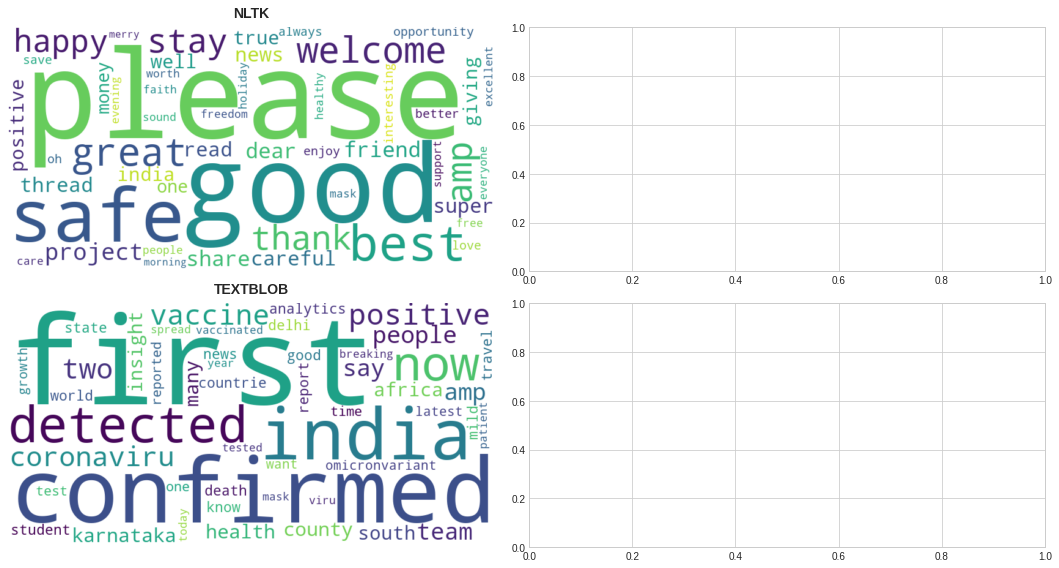

In [162]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
plt.suptitle('', fontsize=30)

ax[0,0].imshow(wordcloud_nltk_pos, interpolation="bilinear")
ax[0,0].axis("off")
ax[0,0].set_title('NLTK')

ax[1,0].imshow(wordcloud_blob_pos, interpolation="bilinear")
ax[1,0].axis("off")
ax[1,0].set_title('TEXTBLOB')




plt.tight_layout()
plt.show()

Judging by the wordcloud, it looks like NLTK  tool give us strong emotional words like 'Please'.


In [163]:
df.text[df['sentiment_nltk']=='pos'].sample(10).values

array(['Giveaway $1000 PayPal Gift Card Win a free PayPal gift card worth $1000 \nhttps://t.co/Aj0hm63VRJ\n\n #free 2022… https://t.co/FMtq7yk8HB',
       'clear as day #omicron https://t.co/DUbww6w3Em',
       'Who do I trust?\n\n#Omicron https://t.co/sQfHf7LaPC',
       '@antheanton Pretty certain #Covid &amp; #Omicron doesn’t take negotiations &amp; would love a welcoming unmasked super spre… https://t.co/SJxhYcko8a',
       'Natural Beauty... \n\n#nature #NaturePhotography #naturelovers #NatureBeauty #bachelorette #Omicron https://t.co/tlbi5JpKJn',
       'True #Omicron 🤣 https://t.co/1ufBPTSl5e',
       "It's always a pleasure seeing my clients happy !!\nThank you for your unconditional trust and am so happy you got yo… https://t.co/oJqzJZVJoy",
       'Guys - it’s SuPEr MutAteD!!!!!!! #Omicron https://t.co/92fyce4As5 https://t.co/fKiducKY0z',
       'Beautiful \nLast month of 2021\nBe careful with #Omicron https://t.co/MQUqlRKrZH',
       "Wish Media doesn't create Fear on #Omicr

In [164]:
df.text[df['sentiment_blob']=='pos'].sample(10).values

array(['Growth in 7D US Confirmed Covid Deaths by County For OK   2021-11-29:  Covid Insights From Our Analytics Team and U… https://t.co/iGXoZFSLbe',
       'Covid: \n“If you live in #FL while the positivity rate is &lt;4%, now is a good time to make those doctor’s appointment… https://t.co/LD1jVh84rX',
       'Omicron could hit demand, might not slow inflation - BoE’s Catherine Mann. #BoE #Omicron  https://t.co/kmHCGp8UmG',
       '#Omicron pressures and now the Chicago #PMI out with a large miss here. https://t.co/PV7LZrjlev',
       'Fred Pleitgen to Brianna Keilar:\n\nGER is having a spike in #COVID19 cases, many among xtrm RW AFD who refuse to… https://t.co/vIS3UsXFtn',
       'Relief in South Africa as Omicron variant appears to be ‘a super mild‘ mutation\n\nWHO and #Coronavirus experts are i… https://t.co/WnrXFhvwVi',
       'The new super mutant #COVID19 variant #Omicron appears to be very transmissible, top microbiologist and virologist… https://t.co/IV57a6wENM',
       'US s

In [166]:
df_all_pos = df[(df['sentiment_nltk']=='pos') & (df['sentiment_blob']=='pos')]

In [167]:
len(df_all_pos)

177

In [168]:
df_all_pos['text_clean'].sample(10).values

array([' omicron sounds cool', 'smart kids', 'so true. people be careful',
       'oh allah save my beloved country from',
       'shorting pfizer and moderna shares is probably the best play going',
       'welcome back', '24% positive rate ...',
       'the true hero we need against', 'welcome',
       'hoping for the best case scenario !!'], dtype=object)

In [169]:
texts_pos = " ".join(sentiment for sentiment in df_all_pos['text_clean'])

In [170]:
wordcloud_pos = WordCloud(width=900,
                      stopwords=stopwords,
                      height=500,
                      max_font_size=300,
                      max_words=100,
                      collocations=False,
                      background_color='white').generate(texts_pos)

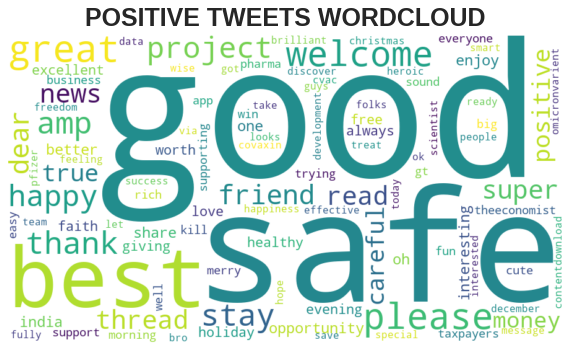

In [172]:
plt.figure(figsize=(9,5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title('POSITIVE TWEETS WORDCLOUD', fontsize=25)
plt.show()

In [173]:
texts_nltk_neg = " ".join(sentiment for sentiment in df[df['sentiment_nltk']=='neg']['text_clean'])
texts_blob_neg = " ".join(sentiment for sentiment in df[df['sentiment_blob']=='neg']['text_clean'])


In [174]:

wordcloud_nltk_neg = WordCloud(width=800,
                      stopwords=stopwords,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_nltk_neg)
wordcloud_blob_neg = WordCloud(width=800,
                      stopwords=stopwords,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_blob_neg)


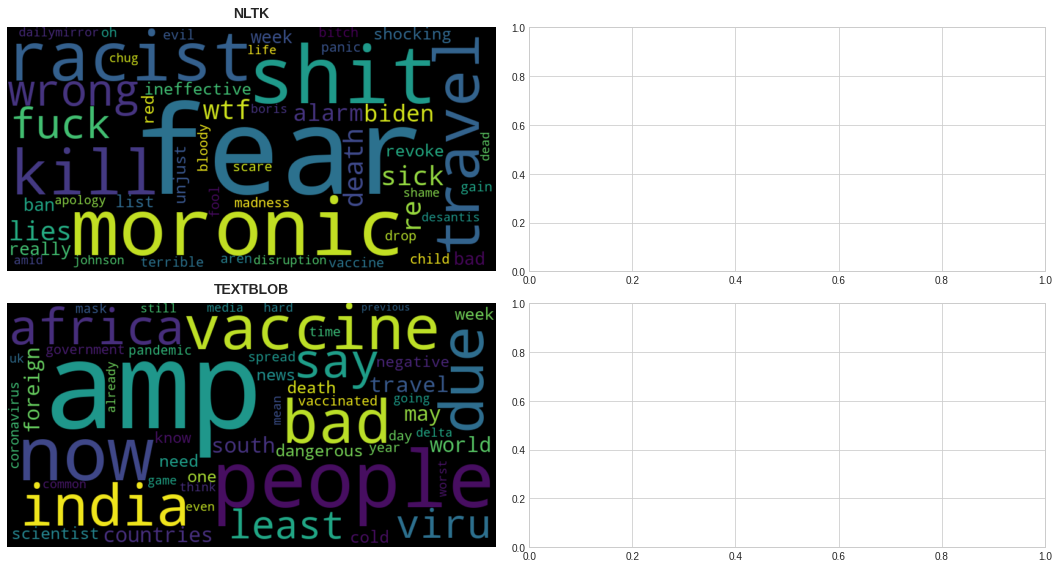

In [175]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
plt.suptitle('', fontsize=30)

ax[0,0].imshow(wordcloud_nltk_neg, interpolation="bilinear")
ax[0,0].axis("off")
ax[0,0].set_title('NLTK')

ax[1,0].imshow(wordcloud_blob_neg, interpolation="bilinear")
ax[1,0].axis("off")
ax[1,0].set_title('TEXTBLOB')




plt.tight_layout()

plt.show()

Judging by the wordcloud, it looks like NLTK  tool give us strong emotional words like 'Fear'.


In [176]:
df.text[df['sentiment_nltk']=='neg'].sample(10).values

array(['Grandma died, so lets destroy liberty forever #Covid19 #Pandemic #Omicron #EnoughIsEnough https://t.co/oW3Dh91F25',
       '@S_Ansari2 @BBhuttoZardari @AseefaBZ @BakhtawarBZ @abro_sapna @BhttoForce @Majid_Bajeer786 @Shahab12062674… https://t.co/EbppnqCNLt',
       '@ChylowHallPPC #Omicron is scary 😨  😆  \n\nBOO https://t.co/3nFWsagCky',
       '8 #Omicron suspects test negative in #Kerala\nhttps://t.co/2qv69OaZ9e',
       '@santheepnair @KALLIVAYALIL @MumbaiLiveNews @TrafflineMUM @RoadsOfMumbai @Wassup_Mumbai @Mumbaikhabar9 @mumbai_ads… https://t.co/YM7Wlih7B4',
       '@RepAndyBiggsAZ @JayMarcieski Funny, 200 million Americans didn’t have such problems. WTF is wrong with you?… https://t.co/H8xY05OA1h',
       '@jkenney Really?? Fool!! #Omicron #ableg\n#cdnpoli\nhttps://t.co/7O3YN2x8Sx',
       'SHOCKING! Man kills wife, children, amid #Omicron fears\n\n#OmicronVariant #COVID19 \n\nhttps://t.co/DBqqp7xJKE',
       'People who block comments really really irritate me #Omicron ht

In [177]:
df.text_clean[df['sentiment_blob']=='neg'].sample(10).values

array(['goldman sachs: omicron variantomicron may mean stock market rally is on hold, chart',
       '. on omicron alarmism: “in florida, we will not let them lock you down. we will not let them take y…',
       'don’t be careless; be responsible!the ones refusing to wear masks will be the reason why we end up closing down a…',
       'alexa it’s omicron not comic con ffs',
       'the thirdwave threat is real. fully vaccinated are falling ill. omicron may or may not be here yet, but covid 19…',
       "arrogant, ignorant &amp; very dangerous borisjohnson hypocrite  around '40 or 50' people were said to have been cr…",
       ' license sold! coronavius evil christmas santa character vectorart bluedarkart thechameleonart …',
       "not if it's worse. covid19 has been attacking brains since the beginning. 45 million in…",
       'idiot! 50% of covid hospitalization in israel were vacc…',
       "it's not enough to remove this disgusting, lying, deceitful govtevery single politician that

In [178]:
df_all_neg = df[(df['sentiment_nltk']=='neg') & (df['sentiment_blob']=='neg')]

In [179]:
len(df_all_neg)

50

In [180]:
df_all_neg['text_clean'].sample(10).values

array([' omicron fear ... she killed her husband.. staysafe everyone',
       ' omicron is scary     boo',
       'grandma died, so lets destroy liberty forever',
       'what the fuck is wrong with you',
       ' omicron you crazy son of a bitch', 'serious', 'desperate fool',
       'forced vaccine??? no!!! all politicians first medicalapartheid together…',
       ' borisjohnson will kill both with his criminal negligence.',
       'yea, seriously!'], dtype=object)

In [181]:
texts_neg = " ".join(sentiment for sentiment in df_all_neg['text_clean'])

In [182]:
wordcloud_neg = WordCloud(width=900,
                      stopwords=stopwords,
                      height=500,
                      max_font_size=200,
                      max_words=60,
                      collocations=False,
                      background_color='black').generate(texts_neg)

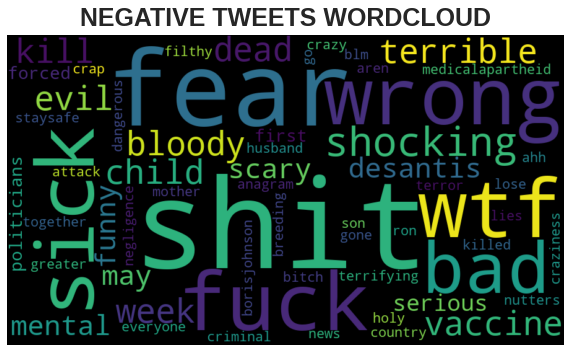

In [183]:
plt.figure(figsize=(9,5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title('NEGATIVE TWEETS WORDCLOUD', fontsize=25)
plt.show()